## Patience Conditions and Stability Conclusions in Buffer Stock Models

   - ["Aggregating heterogeneous-agent models with permanent income shocks"](https://doi.org/10.1016/j.jedc.2021.104185)

## Authors: [Christopher D. Carroll](http://www.econ2.jhu.edu/people/ccarroll/), [Mateo Velásquez-Giraldo](https://mv77.github.io/)

This notebook uses the [Econ-ARK/HARK](https://econ-ark.org) toolkit to examine the circumstances under which a "balanced growth" equilibrium will characterize the dynamics of aggregate variables in a small open economy populated by savers whose behavior is described by the [Buffer Stock Theory](https://econ-ark.github.io/BufferStockTheory) of saving ('BST').

`# Set Up the Computational Environment: (in JupyterLab, click the dots)`

In [2]:
# Preliminaries and default setup

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import copy, deepcopy
import logging

from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType
)

from HARK.ConsumptionSaving.tests.test_IndShockConsumerType import (
    dict_harmenberg    
)

# Define a function that gets all the stats we need
def sumstats(mat):    
    # row means
    log_m = np.mean(np.log(mat), axis = 1)
    # row st_devs
    log_sd = np.std(np.log(mat), axis = 1)
    
    return {'mean-log': log_m, 'sd-log' : log_sd}

# Calculate the moving average
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### The Szeidl 'Growth Impatience Condition'

$\newcommand{\PermShk}{\pmb{\Psi}}$
$\newcommand{\PermGroFac}{\pmb{\Phi}}$
$\newcommand{\pLvl}{\mathbf{p}}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Rfree}{\mathsf{R}}$
$\newcommand{\DiscFac}{\beta}$
$\newcommand{\CRRA}{\rho}$
$\newcommand{\APFac}{\text{\Th}}$
$\newcommand{\GPFac}{\APFac/\PermGroFac}$
$\newcommand{\mLvl}{\mathbf{m}}$
$\newcommand{\cLvl}{\mathbf{c}}$
$\newcommand{\mNrm}{m}$
$\newcommand{\cNrm}{c}$

Using the terminology and notation of BST, the labor income process is assumed to incorporate permanent shocks $\PermShk$ and to exhibit a mean growth factor $\PermGroFac$; that is, each individual's permanent income evolves according to 
\begin{align}
\pLvl_{t+1} & = \PermGroFac \PermShk_{t+1} \pLvl_{t}
\end{align}
where $\Ex_{t}[\PermShk_{t+n}]=1~\forall~n>0$

Agents with constant relative risk aversion coefficient $\CRRA$ have a pure time preference factor $\DiscFac$ and the aggregate interest factor is constant at $\Rfree$ choose a level of consumption $\cLvl$ subject to a budget constraint that links current market resources $\mLvl_{t}$ to next period's $\mLvl_{t+1}$.

<!-- copy trick from BST notebook for rendering thorn -->

Defining the [Absolute Patience Factor](https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#APFac) as
\begin{align}
\APFac & = \left(\Rfree \DiscFac\right)^{1/\CRRA},
\end{align}
and it is easy to show if $\PermShk_{t+n}=1~\forall~n$ (that is, there are no 'shocks' to permanent income, and there are also no transitory shocks), the growth factor for the ratio of consumption to permanent income $\cNrm$ will be
\begin{align}
\GPFac & = \APFac/\PermGroFac
\end{align}
where $\Ex_{t}[\PermShk_{t+n}]=1~\forall~n>0$

Szeidl (2013) shows that the economy will exhibit an invariant distribution of the market resource ratio $\mNrm$ and other variables as long as what we will call the [Growth Impatience Condition-Szeidl]() holds:

\begin{align}
\log \GPFac & < \Ex_{t}[\Delta \log \PermShk_{t+1}]
\end{align}

The HARK toolkit contains code to test this condition and others that have a bearing on the nature of the solution to the model.  

# Calibration and Conditions

In [18]:
# Create an infinite horizon agent with the default parametrization
DiscFac = 0.98
PShkStd = 0.20
PShkVar = PShkStd**2
PShk_add = PShkVar/2

params_test = copy(dict_harmenberg)

params = {
    'LivPrb': [1.0],
    'PermGroFac': [1.0],
    'DiscFac': DiscFac,
    'CRRA': 2.0,
    'Rfree': 1 + PShkVar/2,
    'PermShkStd': [PShkStd],
    'PermShkCount': 5,
    'TranShkStd': [0.1],
    'TranShkCount': 5,
    'UnempPrb': 0.05,
}

params_test.update(params)

base = IndShockConsumerType(**params_test,quietly=True, messaging_level=logging.CRITICAL)
base.cycles = 0  # Inf hor 
base.tolerance = base.tolerance/100 # Insist on accurate soln
base.check_conditions(quietly=True,messaging_level=logging.CRITICAL) # Suppress messages
soln=base.solution[0]
soln.check_GICSdl(soln)
DiscGPFacSdlCusp=base.solution[0].Bilt.DiscGPFacSdlCusp
params = {'DiscFac':DiscGPFacSdlCusp+0.01}
params_test.update(params)
base = IndShockConsumerType(**params_test,quietly=True, messaging_level=logging.CRITICAL)
base.cycles = 0  # Inf hor 
base.tolerance = base.tolerance/100 # Insist on accurate soln
# Again increase the range
base.aXtraMax = base.aXtraMax * 10

# and gridpoints
base.aXtraCount = base.aXtraCount * 2

base.update_assets_grid()

# and decrease error tolerance
base.tolerance = base.tolerance/100
base.solution[0].Bilt.stge_kind['iter_status'] = 'iterator'
# continue solving
base.solve(messaging_level=logging.DEBUG, quietly=False)

base.check_conditions(quietly=True,messaging_level=logging.CRITICAL) # Suppress messages
base.solve()
soln=base.solution[0]
soln.check_GICSdl(soln)



The Szeidl Growth Patience Factor GPFacSdl=1.01790 violates the Szeidl Growth Impatience Condition (GICSdl), GPFacSdl < 1:
    https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#GICSdlDefn

    Therefore, invariant distributions of ratio variables like m do not exist.  


The Szeidl Growth Patience Factor GPFacSdl=1.01790 violates the Szeidl Growth Impatience Condition (GICSdl), GPFacSdl < 1:
    https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#GICSdlDefn
    Therefore, invariant distributions of ratio variables like m do not exist.  



......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.9558452957176427
	LivPrb: 1.0
	CRRA: 2.0
	Rfree: 1.02
	PermGroFac: 1.0
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f9fe01428e0>
	PermShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f9fe095d8e0>
	TranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f9fc04caaf0>
	BoroCnstArt: 0.0
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * PermShk)
	bNrm = kNrm * RNrm
	yNrm = TranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APFac=0.98740 satisfies the Absolute Impatience Condition (AIC), A

..........

\begin{align}
(\Rfree \DiscFac)^{1/\CRRA} & = \PermGroFac \exp(\Ex_{t}[\log \PermShk_{t+1}])
\\ \DiscFac & = \Rfree^{-1}\left(\PermGroFac \exp(\Ex_{t}[\log \PermShk_{t+1}])\right)^{\CRRA}
\end{align}

### Confirmation by Simulation

We can confirm the proposition numerically by simulating the behavior of a large number of such consumers.  

In [19]:
base.T_sim = 5000
base.AgentCount = 20000
base.track_vars=[ 'mNrm','cNrm','pLvl','PermShk','TranShk']
base.solve(quietly=True,messaging_level=logging.CRITICAL)

popn=deepcopy(base)  # popn signifies population weighted

popn.update_income_process()
popn.initialize_sim()
popn.simulate()

C_popn = np.mean(popn.history['cNrm'] * popn.history['pLvl'], axis = 1)
P_popn = np.mean(popn.history['pLvl'], axis = 1)
PermShk_popn = np.mean(popn.history['PermShk'], axis = 1)

m_dstn_popn = deepcopy(popn.history['mNrm'])
P_dstn_popn = deepcopy(popn.history['pLvl'])

The model has already been solved.


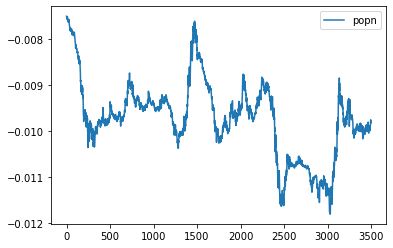

In [21]:
burnin=500
mv_avg_len=1000
# Growth rates of aggregate consumption
c_growth_popn = moving_average(np.diff(np.log(C_popn[burnin:])),mv_avg_len)

plt.figure()
plt.plot(c_growth_popn, label = 'popn')
#plt.plot(c_growth_ntrl, label = 'ntrl')
#plt.plot(c_growth_norm, label = 'norm')
#plt.plot(c_growth_nmnt, label = 'nmnt')
plt.legend()
plt.show()

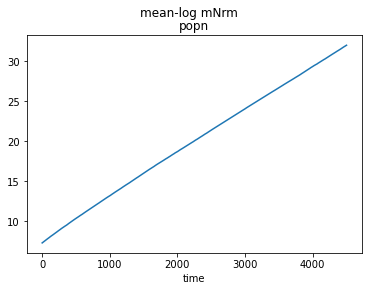

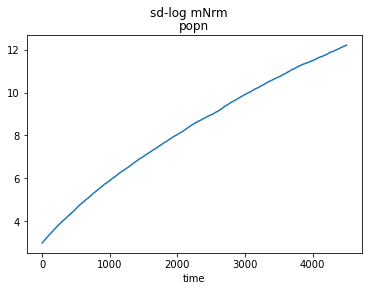

In [22]:
popn_m_stats = sumstats(m_dstn_popn)

avg_max=np.max(popn_m_stats['mean-log'][burnin:])*1.1
avg_min=np.min(popn_m_stats['mean-log'][burnin:])*0.9
std_max=np.max(popn_m_stats['sd-log'][burnin:])*1.1
std_min=np.min(popn_m_stats['sd-log'][burnin:])*0.9

characts = ['mean-log', 'sd-log']
c_min, c_max = avg_min, avg_max
i=0
for c in characts:
    i = i+1
    if i == 2:
        c_min, c_max = std_min, std_max
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle(c + ' mNrm')
    ax1.plot(popn_m_stats[c][burnin:])
    ax1.set_title('popn')
#    ax1.set_ylabel(c)
    ax1.set_xlabel('time')
    plt.show()

### Outline for rest of notebook:


#### GICSdl Fails, GICRaw Holds

Do parallel analysis to the above for a case where the GICSdl fails (set the time pref factor so that the GPFacSdl is halfway between the Sdl 'cusp' and the 'cusp' for the raw GIC

Note the interesting fact that though the mean and standard deviations do not converge, the growth rate of consumption DOES

#### Introduce Harmenberg Condition

Describe GICHrm and then show that the example above satisfies "GICHrm Holds"

Add plots for the neutral measure of $m$ and show that the simulated results confirm Harm the way the original sims confirmed Sdl

Finally, briefly refer to and recap the new 'conjecture' in the last section of BST, with the  sim evidence from the appendix strongly suggesting that the $\Omega$ terms are constant.

#### GICHrm Holds, GICRaw Fails

Further plots showing by simulation that in the GICHrm-Holds, GICRaw-Fails case, the growth rate of consumption asymptotes to APFac but that it seems that the neutral measure does NOT behave well (there is a 'noise catastrophe').  

Speculate that this reflects the failure of the 'mixing' condition required to apply the tools used in the Szeidl proof.


Remaining content below is preserved as a resource for constructing the envisioned notebook above.  It should be deleted in the final version of the notebook we send to Szeidl.  However, a separate notebook (with _private_ somewhere in the filename) should be preserved to illustrate the point that the normalization trick can be used with the Harmenberg trick, and that for small samples the deployment of the two tricks together drastically improves noise (which is my preliminary conclusion).

## Check Harmenberg + Szeidl

In [6]:
from HARK.distribution import calc_expectation

thorn_G = (base.Rfree * base.DiscFac) ** (1/base.CRRA) / base.PermGroFac[0]

e_log_PermShk_Sdl = calc_expectation(base.PermShkDstn[0], func = lambda x: np.log(x))
e_log_PermShk_Hrm = calc_expectation(base.PermShkDstn[0], func = lambda x: x*np.log(x))

cdtn_szeidl = np.log(thorn_G) < e_log_PermShk_Sdl
cdtn_harmen = np.log(thorn_G) < e_log_PermShk_Hrm

print('e_log_PermShk_Sdl',e_log_PermShk_Sdl)
print('e_log_PermShk_Hrm',e_log_PermShk_Hrm)

if cdtn_szeidl:
    print("Szeidl's condition is satisfied, there is a stable invariant distribution of normalized market resources")
    print("The GPFacSdl = ",thorn_G/np.exp(e_log_PermShk_Sdl))
else:
    print("Warning: Szeidl's condition is not satisfied")
if cdtn_harmen:
    print("Harmenberg's condition is satisfied, there is a stable invariant permanent-income-weighted distribution")
    print("The GPFacHrm = ",thorn_G/np.exp(e_log_PermShk_Hrm))
else:
    print("Warning: Harmenberg's condition is not satisfied")

e_log_PermShk_Sdl -0.004484632660240229
e_log_PermShk_Hrm 0.004479640505986558
Szeidl's condition is satisfied, there is a stable invariant distribution of normalized market resources
The GPFacSdl =  0.9968819210938099
Harmenberg's condition is satisfied, there is a stable invariant permanent-income-weighted distribution
The GPFacHrm =  0.9879855336370519


In [8]:
base.solve(quietly=False,messaging_level=logging.WARNING)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [23]:
# Simulation specs revise if desired
popn = deepcopy(base)
ntrl = deepcopy(base) # ntrl = neutral
norm = deepcopy(base) # norm = normalized
nmnt = deepcopy(base) # neutral and normalized (to see whether they work well together)

# Simulation

In [24]:
# Popn
popn.update_income_process()
popn.initialize_sim()
popn.simulate()

C_popn = np.mean(popn.history['cNrm'] * popn.history['pLvl'], axis = 1)
P_popn = np.mean(popn.history['pLvl'], axis = 1)
PermShk_popn = np.mean(popn.history['PermShk'], axis = 1)

m_dstn_popn = deepcopy(popn.history['mNrm'])
P_dstn_popn = deepcopy(popn.history['pLvl'])

In [25]:
# Permanent Income Neutral
ntrl.neutral_measure = True
ntrl.update_income_process()
ntrl.initialize_sim()
ntrl.simulate()

C_ntrl = np.mean(ntrl.history['cNrm'], axis = 1)
P_ntrl = np.mean(ntrl.history['pLvl'], axis = 1)
PermShk_ntrl = np.mean(ntrl.history['PermShk'], axis = 1)

m_dstn_ntrl = deepcopy(ntrl.history['mNrm'])
P_dstn_ntrl = deepcopy(ntrl.history['pLvl'])

In [26]:
# Normed
norm.normalize_levels = True
norm.normalize_shocks = True
#norm.update_income_process()

norm.initialize_sim()
norm.simulate()
C_norm = np.mean(norm.history['cNrm'] * norm.history['pLvl'], axis = 1)
P_norm = np.mean(norm.history['pLvl'], axis = 1)
PermShk_norm = np.mean(norm.history['pLvl'], axis = 1)

m_dstn_norm = deepcopy(norm.history['mNrm'])
P_dstn_norm = deepcopy(norm.history['pLvl'])

In [27]:
# Normed and neutralized
nmnt = deepcopy(base)
nmnt.neutral_measure = True
nmnt.normalize_levels = True
nmnt.normalize_shocks = True

nmnt.update_income_process()
nmnt.initialize_sim()
nmnt.simulate()

C_nmnt = np.mean(nmnt.history['cNrm'] * nmnt.history['pLvl'], axis = 1)
P_nmnt = np.mean(nmnt.history['pLvl'], axis = 1)
PermShk_nmnt = np.mean(nmnt.history['pLvl'], axis = 1)

m_dstn_nmnt = deepcopy(nmnt.history['mNrm'])
P_dstn_nmnt = deepcopy(nmnt.history['pLvl'])

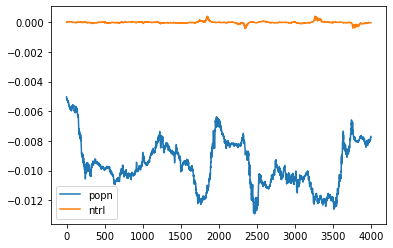

In [28]:
burnin=500
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

mv_avg_len=500
# Growth rates of aggregate consumption
c_growth_popn = moving_average(np.diff(np.log(C_popn[burnin:])),mv_avg_len)
c_growth_ntrl = moving_average(np.diff(np.log(C_ntrl[burnin:])),mv_avg_len)
c_growth_norm = moving_average(np.diff(np.log(C_norm[burnin:])),mv_avg_len)
c_growth_nmnt = moving_average(np.diff(np.log(C_nmnt[burnin:])),mv_avg_len)

plt.figure()
plt.plot(c_growth_popn, label = 'popn')
plt.plot(c_growth_ntrl, label = 'ntrl')
#plt.plot(c_growth_norm, label = 'norm')
#plt.plot(c_growth_nmnt, label = 'nmnt')
plt.legend()
plt.show()

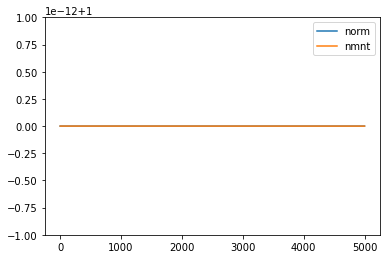

In [35]:
plt.figure()
#plt.plot(P_popn, label = 'popn')
#plt.plot(P_ntrl, label = 'ntrl')
plt.plot(P_norm, label = 'norm')
plt.plot(P_nmnt, label = 'nmnt')
plt.legend()
plt.show()

# Means and variances over time

In [30]:
popn_m_stats = sumstats(m_dstn_popn)
ntrl_m_stats = sumstats(m_dstn_ntrl)
norm_m_stats = sumstats(m_dstn_norm)
nmnt_m_stats = sumstats(m_dstn_nmnt)

P_popn_stats = sumstats(P_dstn_popn)
P_ntrl_stats = sumstats(P_dstn_ntrl)
P_norm_stats = sumstats(P_dstn_norm)
P_nmnt_stats = sumstats(P_dstn_nmnt)

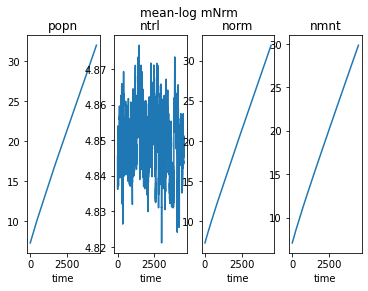

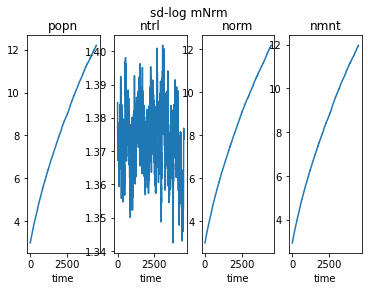

In [31]:
# Plots
avg_max=np.max([np.max(popn_m_stats['mean-log'][burnin:]),
       np.max(ntrl_m_stats['mean-log'][burnin:]*1.3),
       np.max(norm_m_stats['mean-log'][burnin:])]
      )*1.1
avg_min=np.min([np.min(popn_m_stats['mean-log'][burnin:]),
       np.min(ntrl_m_stats['mean-log'][burnin:]*1.3),
       np.min(norm_m_stats['mean-log'][burnin:])]
      )*0.9
std_max=np.max([np.max(popn_m_stats['sd-log'][burnin:]),
       np.max(ntrl_m_stats['sd-log'][burnin:]*0.9/0.5),
       np.max(norm_m_stats['sd-log'][burnin:])]
      )*1.1
std_min=np.min([np.min(popn_m_stats['sd-log'][burnin:]),
       np.min(ntrl_m_stats['sd-log'][burnin:]*0.9/0.5),
       np.min(norm_m_stats['sd-log'][burnin:])]
      )*0.9

characts = ['mean-log', 'sd-log']
c_min, c_max = avg_min, avg_max
i=0
for c in characts:
    i = i+1
    if i == 2:
        c_min, c_max = std_min, std_max
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.suptitle(c + ' mNrm')
    ax1.plot(popn_m_stats[c][burnin:])
    ax1.set_title('popn')
#    ax1.set_ylabel(c)
    ax1.set_xlabel('time')
#    ax1.set_ylim([c_min,c_max])
    ax2.plot(ntrl_m_stats[c][burnin:]*0.9/0.5) # rescale to fit on common axis
    ax2.set_title('ntrl')
#    ax2.set_ylabel(c)
    ax2.set_xlabel('time')
#    ax2.set_ylim([c_min,c_max])
    ax3.plot(norm_m_stats[c][burnin:])
    ax3.set_title('norm')
#    ax3.set_ylabel(c)
    ax3.set_xlabel('time')
#    ax3.set_ylim([c_min,c_max])
    ax4.plot(nmnt_m_stats[c][burnin:])
    ax4.set_title('nmnt')
#    ax3.set_ylabel(c)
    ax4.set_xlabel('time')
#    ax4.set_ylim([c_min,c_max])
    plt.show()

In [39]:
# Create an infinite horizon agent with the default parametrization
DiscFac = 0.99
PShkStd = 0.10
PShkVar = PShkStd**2
PShk_add = PShkVar/2

params = {
    'LivPrb': [1.0],
    'PermGroFac': [1.0],
    'DiscFac': DiscFac,
    'CRRA': 2.0,
    'Rfree': 1 + PShkVar/2,
    'PermShkStd': [PShkStd],
    'PermShkCount': 5,
    'TranShkStd': [0.1],
    'TranShkCount': 5,
    'UnempPrb': 0.05,
}

params_test = copy(dict_harmenberg)
params_test.update(params)

base = IndShockConsumerType(**params_test,quietly=True, messaging_level=logging.CRITICAL)
base.cycles = 0  # Inf hor 
base.tolerance = base.tolerance/100 # Insist on accurate soln

# Check conditions

base.check_conditions(quietly=True, messaging_level=logging.DEBUG)


The Absolute Patience Factor, APFac=0.99747 satisfies the Absolute Impatience Condition (AIC), APFac < 1:
    https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#AIC

    Because the APFac < 1,  the absolute amount of consumption is expected to fall over time.  


The Finite Human Wealth Factor, FHWFac=0.99502 satisfies the Finite Human Wealth Condition (FHWC), FHWFac < 1:
    https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#FHWC

    Therefore, the limiting consumption function is not c(m)=Infinity.

    Human wealth normalized by permanent income is 201.00000.


The Return Patience Factor, RPFac=0.99251 satisfies the Return Impatience Condition (RIC), RPFac < 1:
    https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#RPFacDefn

    Therefore, the limiting consumption function is not c(m)=0 for all m


The Growth Patience Factor, GPF=0.99747 satisfies the Growth Impatience Condition (GICRaw), GPF < 1:
    https://econ-ark.github.i